In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from skimage.io import imsave
import os
import shutil

img_height = 28
img_width = 28
img_size = img_height * img_width

to_train = True
to_restore = False
output_path = "output"

max_epoch = 500

h1_size = 150
h2_size = 300
z_size = 100
batch_size = 256

# 일반적인 GAN 의 형태 입니다.
# 라벨을 구분하지 않습니다.

# 제너레이터 (G)
def build_generator(z_prior):
    # Fully Connected Layer 1 (100 (latent-vector) -> 150 (h1_size))
    w1 = tf.Variable(tf.truncated_normal([z_size, h1_size], stddev=0.1), name="g_w1", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h1_size]), name="g_b1", dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(z_prior, w1) + b1)

    # Fully Connected Layer 2 (150 (h1_size) -> 300 (h2_size))
    w2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=0.1), name="g_w2", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h2_size]), name="g_b2", dtype=tf.float32)
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)

    # Fully Connected Layer 3 (300 (h1_size) -> input_height * input_width (img_size))
    w3 = tf.Variable(tf.truncated_normal([h2_size, img_size], stddev=0.1), name="g_w3", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([img_size]), name="g_b3", dtype=tf.float32)
    h3 = tf.matmul(h2, w3) + b3
    # 마지막은 활성화함수 tanh 로
    x_generate = tf.nn.tanh(h3)

    # generator 변수 저장
    g_params = [w1, b1, w2, b2, w3, b3]

    return x_generate, g_params

# 디스크리미네이터 (D)
def build_discriminator(x_data, x_generated, keep_prob):
    # 실제 이미지와 생성된 이미지를 합침
    x_in = tf.concat([x_data, x_generated], 0) 

    # Fully Connected Layer 1 (input_height * input_width (img_size) -> 200 (h2_size)) , dropout
    w1 = tf.Variable(tf.truncated_normal([img_size, h2_size], stddev=0.1), name="d_w1", dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h2_size]), name="d_b1", dtype=tf.float32)
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_in, w1) + b1), keep_prob)

    # Fully Connected Layer 2 (200 (h1_size) -> 150 (h1_size)) , dropout
    w2 = tf.Variable(tf.truncated_normal([h2_size, h1_size], stddev=0.1), name="d_w2", dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([h1_size]), name="d_b2", dtype=tf.float32)
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1, w2) + b2), keep_prob)

    # Fully Connected Layer 3 (150 (h1_size) -> 1)
    w3 = tf.Variable(tf.truncated_normal([h1_size, 1], stddev=0.1), name="d_w3", dtype=tf.float32)
    b3 = tf.Variable(tf.zeros([1]), name="d_b3", dtype=tf.float32)
    h3 = tf.matmul(h2, w3) + b3

    # batch_size 만큼 잘라 각각 y_data, y_generated 로
    # ex)
    #   이미지 60000개, 배치 사이즈 256, 이미지 사이즈 28 * 28 이라면
    #   h3 shape : (257, 1)
    #   y_data shape : (256, 1)
    #   y_generated shape : (1, 1) 
    y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0], [batch_size, -1], name=None))
    y_generated = tf.nn.sigmoid(tf.slice(h3, [batch_size, 0], [-1, -1], name=None))

    # discriminator 변수 저장
    d_params = [w1, b1, w2, b2, w3, b3]

    return y_data, y_generated, d_params

# 결과 저장 (이미지)
def show_result(batch_res, fname, grid_size=(8, 8), grid_pad=5):
    batch_res = 0.5 * batch_res.reshape((batch_res.shape[0], img_height, img_width)) + 0.5
    img_h, img_w = batch_res.shape[1], batch_res.shape[2]
    grid_h = img_h * grid_size[0] + grid_pad * (grid_size[0] - 1)
    grid_w = img_w * grid_size[1] + grid_pad * (grid_size[1] - 1)
    img_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)
    for i, res in enumerate(batch_res):
        if i >= grid_size[0] * grid_size[1]:
            break
        img = (res) * 255.
        img = img.astype(np.uint8)
        row = (i // grid_size[0]) * (img_h + grid_pad)
        col = (i % grid_size[1]) * (img_w + grid_pad)
        img_grid[row:row + img_h, col:col + img_w] = img
    imsave(fname, img_grid)


def train():
    # mnist 로 학습할 경우
    # mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    
    # phd08 로 학습할 경우
    phd08 = np.load('exampledata/phd08_data_1.npy')
    size = phd08.shape[0]
    phd08 = phd08.reshape((size,784))

    x_data = tf.placeholder(tf.float32, [batch_size, img_size], name="x_data") # (batch_size, img_size)
    z_prior = tf.placeholder(tf.float32, [batch_size, z_size], name="z_prior") # (batch_size, z_size)
    keep_prob = tf.placeholder(tf.float32, name="keep_prob") # dropout 퍼센트
    global_step = tf.Variable(0, name="global_step", trainable=False)

    # x_generated : generator 가 생성한 이미지, g_params : generater 의 TF 변수들
    x_generated, g_params = build_generator(z_prior)
    # 실제이미지, generater 가 생성한 이미지, dropout keep_prob 를 넣고 discriminator(경찰) 이 감별
    y_data, y_generated, d_params = build_discriminator(x_data, x_generated, keep_prob)

    # loss 함수 ( D 와 G 를 따로 ) *
    d_loss = - (tf.log(y_data) + tf.log(1 - y_generated))
    g_loss = - tf.log(y_generated)

    # optimizer : AdamOptimizer 사용 *
    optimizer = tf.train.AdamOptimizer(0.0001)

    # discriminator 와 generator 의 변수로 각각의 loss 함수를 최소화시키도록 학습
    d_trainer = optimizer.minimize(d_loss, var_list=d_params)
    g_trainer = optimizer.minimize(g_loss, var_list=g_params)

    init = tf.global_variables_initializer()

    saver = tf.train.Saver()

    sess = tf.Session()

    sess.run(init)

    if to_restore:
        chkpt_fname = tf.train.latest_checkpoint(output_path)
        saver.restore(sess, chkpt_fname)
    else:
        if os.path.exists(output_path):
            shutil.rmtree(output_path)
        os.mkdir(output_path)

    z_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)

    for i in range(sess.run(global_step), max_epoch):
        for j in range(21870 // batch_size):
            print("epoch:%s, iter:%s" % (i, j))

            # x_value, _ = mnist.train.next_batch(batch_size)
            # x_value = 2 * x_value.astype(np.float32) - 1
            # print(x_value[0])

            batch_end = j * batch_size + batch_size
            if batch_end >= size:
                batch_end = size - 1
            x_value = phd08[ j * batch_size : batch_end ]
            x_value = x_value / 255.
            x_value = 2 * x_value - 1

            z_value = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
            sess.run(d_trainer,
                     feed_dict={x_data: x_value, z_prior: z_value, keep_prob: np.sum(0.7).astype(np.float32)})
            if j % 1 == 0:
                sess.run(g_trainer,
                         feed_dict={x_data: x_value, z_prior: z_value, keep_prob: np.sum(0.7).astype(np.float32)})
        x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_sample_val})
        show_result(x_gen_val, os.path.join(output_path, "sample%s.jpg" % i))
        print(x_gen_val)
        z_random_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
        x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_random_sample_val})
        show_result(x_gen_val, os.path.join(output_path, "random_sample%s.jpg" % i))
        sess.run(tf.assign(global_step, i + 1))
        saver.save(sess, os.path.join(output_path, "model"), global_step=global_step)

# 학습 완료 후 테스트 (이미지로 저장)
def test():
    z_prior = tf.placeholder(tf.float32, [batch_size, z_size], name="z_prior")
    x_generated, _ = build_generator(z_prior)
    chkpt_fname = tf.train.latest_checkpoint(output_path)

    init = tf.global_variables_initializer()
    sess = tf.Session()
    saver = tf.train.Saver()
    sess.run(init)
    saver.restore(sess, chkpt_fname)
    z_test_value = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
    x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_test_value})
    show_result(x_gen_val, os.path.join(output_path, "test_result.jpg"))


# if __name__ == '__main__':
#     if to_train:
#         train()
#     else:
#         test()

train()


epoch:0, iter:0
epoch:0, iter:1
epoch:0, iter:2
epoch:0, iter:3
epoch:0, iter:4
epoch:0, iter:5
epoch:0, iter:6
epoch:0, iter:7
epoch:0, iter:8
epoch:0, iter:9
epoch:0, iter:10
epoch:0, iter:11
epoch:0, iter:12
epoch:0, iter:13
epoch:0, iter:14
epoch:0, iter:15
epoch:0, iter:16
epoch:0, iter:17
epoch:0, iter:18
epoch:0, iter:19
epoch:0, iter:20
epoch:0, iter:21
epoch:0, iter:22
epoch:0, iter:23
epoch:0, iter:24
epoch:0, iter:25
epoch:0, iter:26
epoch:0, iter:27
epoch:0, iter:28
epoch:0, iter:29
epoch:0, iter:30
epoch:0, iter:31
epoch:0, iter:32
epoch:0, iter:33
epoch:0, iter:34
epoch:0, iter:35
epoch:0, iter:36
epoch:0, iter:37
epoch:0, iter:38
epoch:0, iter:39
epoch:0, iter:40
epoch:0, iter:41
epoch:0, iter:42
epoch:0, iter:43
epoch:0, iter:44
epoch:0, iter:45
epoch:0, iter:46
epoch:0, iter:47
epoch:0, iter:48
epoch:0, iter:49
epoch:0, iter:50
epoch:0, iter:51
epoch:0, iter:52
epoch:0, iter:53
epoch:0, iter:54
epoch:0, iter:55
epoch:0, iter:56
epoch:0, iter:57
epoch:0, iter:58
epoch:0

KeyboardInterrupt: 

In [1]:
# 털과 날개가 있는지 없는지에 따라, 포유류인지 조류인지 분류하는 신경망 모델을 만들어봅니다.
import tensorflow as tf
import numpy as np

# [털, 날개]
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# [기타, 포유류, 조류]
# 다음과 같은 형식을 one-hot 형식의 데이터라고 합니다.
y_data = np.array([
    [1, 0, 0],  # 기타
    [0, 1, 0],  # 포유류
    [0, 0, 1],  # 조류
    [1, 0, 0],
    [1, 0, 0],
    [0, 0, 1]
])

#########
# 신경망 모델 구성
######
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# 신경망은 2차원으로 [입력층(특성), 출력층(레이블)] -> [2, 3] 으로 정합니다.
W = tf.Variable(tf.random_uniform([2, 3], -1., 1.))

# 편향을 각각 각 레이어의 아웃풋 갯수로 설정합니다.
# 편향은 아웃풋의 갯수, 즉 최종 결과값의 분류 갯수인 3으로 설정합니다.
b = tf.Variable(tf.zeros([3]))

# 신경망에 가중치 W과 편향 b을 적용합니다
L = tf.add(tf.matmul(X, W), b)
# 가중치와 편향을 이용해 계산한 결과 값에
# 텐서플로우에서 기본적으로 제공하는 활성화 함수인 ReLU 함수를 적용합니다.
L = tf.nn.relu(L)

# 마지막으로 softmax 함수를 이용하여 출력값을 사용하기 쉽게 만듭니다
# softmax 함수는 다음처럼 결과값을 전체합이 1인 확률로 만들어주는 함수입니다.
# 예) [8.04, 2.76, -6.52] -> [0.53 0.24 0.23]
model = tf.nn.softmax(L)

# 신경망을 최적화하기 위한 비용 함수를 작성합니다.
# 각 개별 결과에 대한 합을 구한 뒤 평균을 내는 방식을 사용합니다.
# 전체 합이 아닌, 개별 결과를 구한 뒤 평균을 내는 방식을 사용하기 위해 axis 옵션을 사용합니다.
# axis 옵션이 없으면 -1.09 처럼 총합인 스칼라값으로 출력됩니다.
#        Y         model         Y * tf.log(model)   reduce_sum(axis=1)
# 예) [[1 0 0]  [[0.1 0.7 0.2]  -> [[-1.0  0    0]  -> [-1.0, -0.09]
#     [0 1 0]]  [0.2 0.8 0.0]]     [ 0   -0.09 0]]
# 즉, 이것은 예측값과 실제값 사이의 확률 분포의 차이를 비용으로 계산한 것이며,
# 이것을 Cross-Entropy 라고 합니다.
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(model), axis=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(cost)


#########
# 신경망 모델 학습
######
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(100):
    sess.run(train_op, feed_dict={X: x_data, Y: y_data})

    if (step + 1) % 10 == 0:
        print(step + 1, sess.run(cost, feed_dict={X: x_data, Y: y_data}))


#########
# 결과 확인
# 0: 기타 1: 포유류, 2: 조류
######
# tf.argmax: 예측값과 실제값의 행렬에서 tf.argmax 를 이용해 가장 큰 값을 가져옵니다.
# 예) [[0 1 0] [1 0 0]] -> [1 0]
#    [[0.2 0.7 0.1] [0.9 0.1 0.]] -> [1 0]
prediction = tf.argmax(model, 1)
target = tf.argmax(Y, 1)
print('예측값:', sess.run(prediction, feed_dict={X: x_data}))
print('실제값:', sess.run(target, feed_dict={Y: y_data}))

is_correct = tf.equal(prediction, target)
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
print('정확도: %.2f' % sess.run(accuracy * 100, feed_dict={X: x_data, Y: y_data}))


/Users/yerin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


10 1.20875
20 1.20055
30 1.19258
40 1.18494
50 1.17753
60 1.1703
70 1.16338
80 1.15669
90 1.1502
100 1.14387
예측값: [0 1 0 0 0 0]
실제값: [0 1 2 0 0 2]
정확도: 66.67


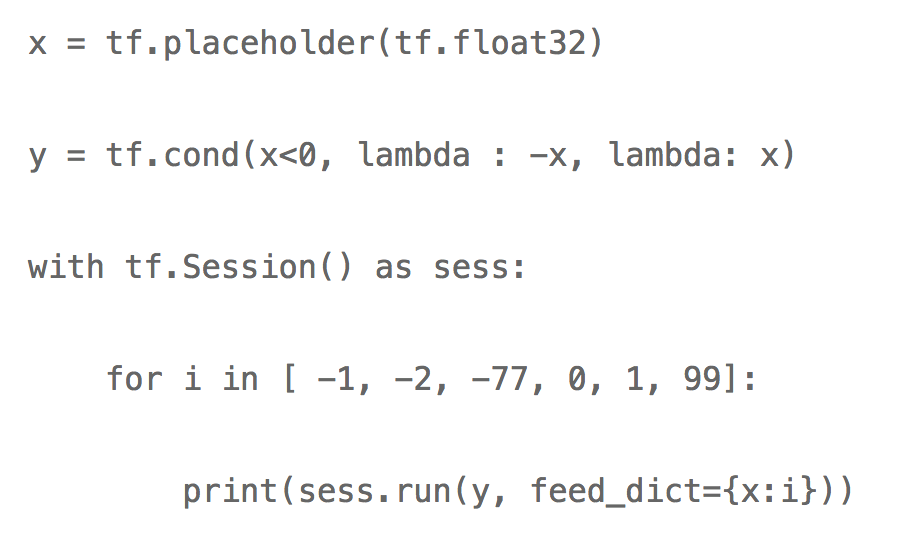

In [26]:
# 텐서플로우의 기본적인 구성을 익힙니다.
import tensorflow as tf

x= tf.placeholder(tf.float32, [None, 10])
y=tf.cond(x<0 , lambda:-x,lambda:x)
xfd=tf.constant(1.)
kd=tf.subtract(1.,y)

sess=tf.Session()
k=sess.run(kd,feed_dict={x:-3})
print(k)

ValueError: Shape must be rank 0 but is rank 2 for 'cond_7/Switch' (op: 'Switch') with input shapes: [?,10], [?,10].

In [14]:
x

0.9136679099414992

In [16]:
from scipy.stats import truncnorm
get_truncated_normal(mean=8, sd=2, low=1, upp=10)

NameError: name 'get_truncated_normal' is not defined

In [25]:
np.random.random([5, 1])

array([[ 0.5770074 ],
       [ 0.89771039],
       [ 0.30697865],
       [ 0.43173968],
       [ 0.33890739]])